# Exploratory Data Analysis 
## MSc Data Science

Imputation: 
- How often do people report x in a row? And does it relate to the multi-morb they have?
- Subsets (can we impute for all symptoms for example)
- For each multi-morb what does symptom assoc look like --> for each multi create matrix of symptom associtions, from there which groups can we make (focus on common multi, not on small groups)
- SO if groups are similar we could impute per group
- If not impute separately
- (NTH: clusters of people with same symptoms, to use for pred based on similar symptom assoc)
- If restr activity can we predict next month, is then the data MNCAR? --> this may mean standard imputation could applicable (check this before imputation) (look at python packages that can find patterns of missingness)

Pred:
- When symptoms increase, does fOutcome increase?
- fOutcome per multi
- dist of of other outcome columns (can it be a better prediction column)


### Import

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#%pip install openpyxl
import openpyxl
#%pip install -U scikit-learn
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.cluster.hierarchy import dendrogram, linkage
#%pip install scipy
import scipy
#!pip install --upgrade scipy seaborn matplotlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#%pip install networkx matplotlib pyvis
import networkx as nx
from itertools import combinations
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
#%pip install statsmodels
import statsmodels.api as sm


In [3]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

### Data loading (Make sure to change this to the original PEP data)

In [4]:
# Opening dummy data v2
path = "dummy_data_v2.xlsx"

df = pd.read_excel(path)

#print(df)

## EDA

### The Symptoms in Numbers 

In [5]:
# Imputing Nans in the symptom columns (assumption: if Nan then 0, 
# because if data is included in the data the assumption is that it was forgotten)
prob_b_columns = [col for col in df.columns if col.startswith('prob_b')]

#df[prob_b_columns] = df[prob_b_columns].fillna(0.0)

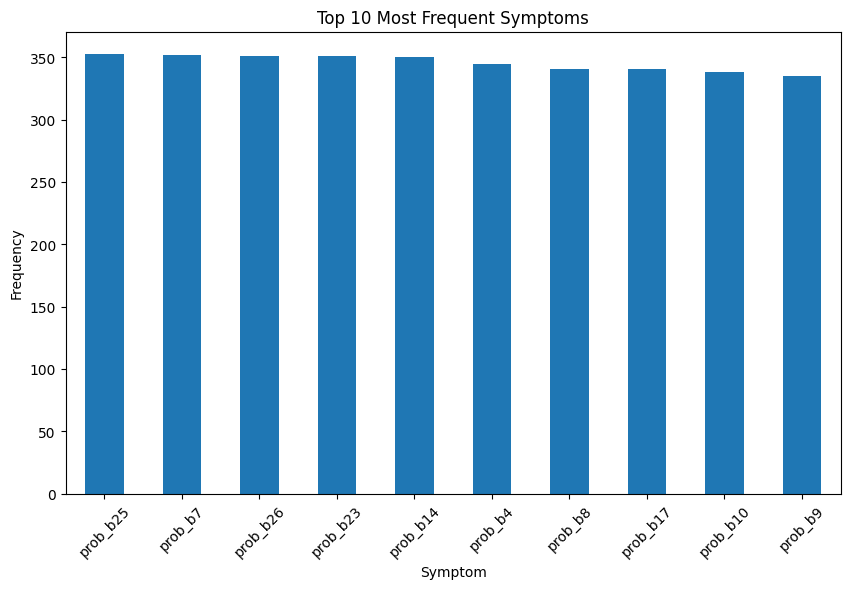

In [6]:
# Top 10 most occurring symptoms
# Filter columns that start with 'prob_b' for symptom data
symptom_columns = [col for col in df.columns if col.startswith('prob_b')]

# Calculate the sum of each symptom
symptom_frequencies = df[symptom_columns].sum().sort_values(ascending=False)

# Select the top 10 most frequent symptoms
top_10_symptoms = symptom_frequencies.head(10)

# Plotting the top 10 most frequent symptoms
plt.figure(figsize=(10, 6))
top_10_symptoms.plot(kind='bar')
plt.title('Top 10 Most Frequent Symptoms')
plt.xlabel('Symptom')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Percentage of people experiencing the symptoms

# Filter columns that start with 'prob_b' for symptom data
symptom_columns = [col for col in df.columns if col.startswith('prob_b')]

symptom_counts = df[symptom_columns].sum()

# Calculate the total number of unique studyIDs in the dataset
total_study_ids = df['studyID'].nunique()

# Calculate the percentage of StudyIDs that have experienced each symptom
symptom_percentages = (symptom_counts / total_study_ids) * 100

# put in df for readabiloty
symptom_percentages_df = symptom_percentages.reset_index().rename(columns={'index': 'Symptom', 0: 'Percentage'})

symptom_percentages_df

Symptom  Percentage
0    prob_b3   54.562044
1    prob_b4   62.956204
2    prob_b5   60.401460
3    prob_b6   60.583942
4    prob_b7   64.233577
5    prob_b8   62.226277
6    prob_b9   61.131387
7   prob_b10   61.678832
8   prob_b11   60.766423
9   prob_b12   58.759124
10  prob_b13   58.576642
11  prob_b14   63.868613
12  prob_b15   59.854015
13  prob_b16   60.036496
14  prob_b17   62.226277
15  prob_b18   60.401460
16  prob_b19   58.211679
17  prob_b20   59.124088
18  prob_b21   58.029197
19  prob_b22   56.386861
20  prob_b23   64.051095
21  prob_b24   57.116788
22  prob_b25   64.416058
23  prob_b26   64.051095

In [8]:
# Number of symptoms per interview on average

# Sum the values across the symptom columns for each row (interview)
df['total_symptoms'] = df[symptom_columns].sum(axis=1)

# Calculate the average number of symptoms reported per interview
average_symptoms_per_interview = df['total_symptoms'].mean()

print(f"Average number of symptoms reported per interview: {average_symptoms_per_interview}")


Average number of symptoms reported per interview: 7.966


#### IMPORTANT: I have added some extra infor such as BMI over 30, but must figure out what exactly are the 9 main diseases in the dataset.

##### Also: where is cancer in the list? --> carcinoma

In [9]:
# Creating a list for all diseases mentioned in PEP:
disease_columns = ['heartattack', 'strokes', 'congestiveHD', 'carcinoma', 'hipfracture', 'chronicLung', 'Hypertension', 'arthritis', 'DM_TG', 'BMI_ge30', 'SCESD_ge16', ]

In [10]:
# The average number of diseases reported per interview (degree of multi-morbidity)
average_diseases_per_interview = df[disease_columns].sum(axis=1).mean()
print(average_diseases_per_interview)

4.046


In [11]:
# Seeing if there is a difference in symptoms reported between F2F and 

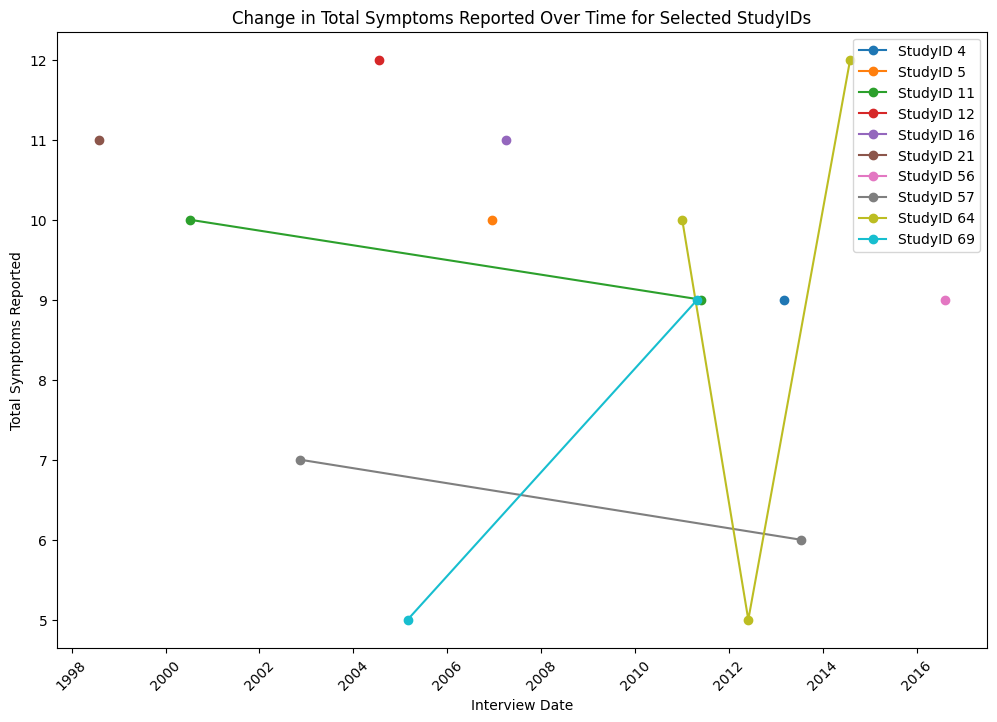

In [12]:
# Changes over time (is there ever a decrease in symptoms?)

df['intdate'] = pd.to_datetime(df['intdate'])

# Sum symptoms for each row to get a total count per interview
df['total_symptoms'] = df[symptom_columns].sum(axis=1)

# Sort the DataFrame by 'studyID' and 'intdate'
df_sorted = df.sort_values(by=['studyID', 'intdate'])

# Group by 'studyID' and calculate the difference in 'total_symptoms' between consecutive interviews
df_sorted['symptom_change'] = df_sorted.groupby('studyID')['total_symptoms'].diff()

# To identify cases with an increase or decrease over time, we can look at the sign of 'symptom_change'
# Positive values in 'symptom_change' indicate an increase in symptoms, and negative values indicate a decrease

# Identify studyIDs with at least one increase in symptoms over time
studyIDs_increasing = df_sorted[df_sorted['symptom_change'] > 0]['studyID'].unique()

# Identify studyIDs with at least one decrease in symptoms over time
studyIDs_decreasing = df_sorted[df_sorted['symptom_change'] < 0]['studyID'].unique()

# Select a few studyIDs for visualization
sample_studyIDs = df_sorted['studyID'].unique()[:10]  # Adjust this for smaller or larger sample

plt.figure(figsize=(12, 8))

for studyID in sample_studyIDs:
    data = df_sorted[df_sorted['studyID'] == studyID]
    plt.plot(data['intdate'], data['total_symptoms'], marker='o', linestyle='-', label=f'StudyID {studyID}')

plt.xlabel('Interview Date')
plt.ylabel('Total Symptoms Reported')
plt.title('Change in Total Symptoms Reported Over Time for Selected StudyIDs')
plt.legend()
plt.xticks(rotation=45)
plt.show()

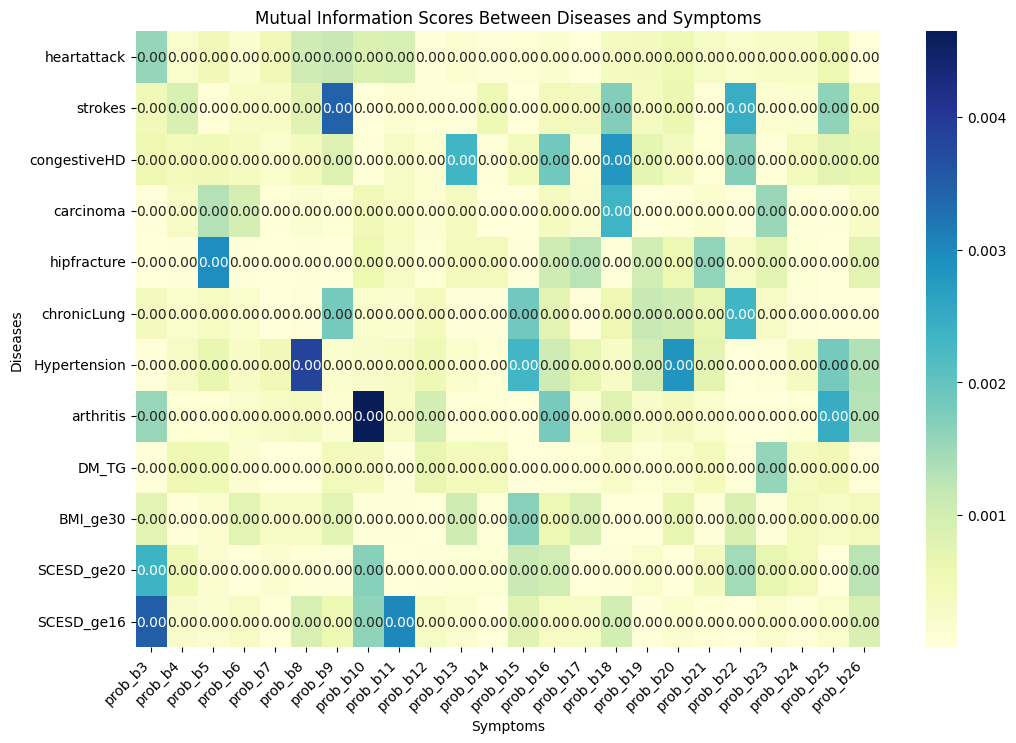

In [13]:
# Disease & Symptoms (which disease matches which symptoms mostly (based on this we can make sub groups))

# Here I used disease and symptom columns, make sure to run that cell first

# Prepare the feature matrix (X) with symptom columns
X = df[symptom_columns].fillna(0)  # Handling NaNs by replacing with 0 (for now, but might need to use mnar techniques here soon)

# Initialize a DataFrame to store mutual information scores
mi_scores_df = pd.DataFrame(index=disease_columns, columns=symptom_columns)

# Calculate mutual information for each disease-symptom pair
for disease in disease_columns:
    y = df[disease].fillna(0)  # Target vector for the disease, handling NaNs
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores_df.loc[disease] = mi_scores

# Convert mi_scores_df to numeric values for visualization
mi_scores_df = mi_scores_df.astype(float)

# Visualization with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mi_scores_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Mutual Information Scores Between Diseases and Symptoms')
plt.xlabel('Symptoms')
plt.ylabel('Diseases')
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
# 

In [15]:
# Relationship for high BMI vs. symptoms (disease specific cohort)

In [16]:
# Relationship smokers or ex-smokers vs. symptoms (behavioral cohort)
# nu:

In [17]:
# Symptom correlation over time

In [18]:
mi_scores_df

prob_b3   prob_b4   prob_b5   prob_b6   prob_b7   prob_b8  \
heartattack   0.001571  0.000211  0.000480  0.000180  0.000479  0.001054   
strokes       0.000472  0.000898  0.000037  0.000280  0.000267  0.000778   
congestiveHD  0.000544  0.000457  0.000502  0.000375  0.000198  0.000413   
carcinoma     0.000036  0.000294  0.001316  0.000964  0.000040  0.000151   
hipfracture   0.000009  0.000026  0.002927  0.000032  0.000009  0.000051   
chronicLung   0.000394  0.000183  0.000341  0.000217  0.000010  0.000062   
Hypertension  0.000036  0.000291  0.000634  0.000277  0.000473  0.003858   
arthritis     0.001548  0.000097  0.000079  0.000196  0.000271  0.000379   
DM_TG         0.000029  0.000560  0.000513  0.000145  0.000014  0.000007   
BMI_ge30      0.000728  0.000033  0.000145  0.000757  0.000260  0.000308   
SCESD_ge20    0.002364  0.000525  0.000127  0.000013  0.000129  0.000043   
SCESD_ge16    0.003474  0.000227  0.000145  0.000305  0.000038  0.000921   

                   prob_b9  prob_b10  prob_b11      prob_b12  prob_b13  \
heartattack   1.155476e-03  0.000859  0.000925  4.785198e-05  0.000125   
strokes       3.429539e-03  0.000006  0.000121  4.403560e-05  0.000027   
congestiveHD  8.401333e-04  0.000054  0.000301  1.262623e-04  0.002322   
carcinoma     9.251174e-05  0.000479  0.000328  1.098438e-04  0.000357   
hipfracture   5.307086e-07  0.000598  0.000312  1.022195e-04  0.000431   
chronicLung   1.849213e-03  0.000208  0.000157  4.278729e-04  0.000040   
Hypertension  1.804218e-04  0.000227  0.000298  5.198414e-04  0.000213   
arthritis     1.266540e-04  0.004644  0.000256  9.959424e-04  0.000068   
DM_TG         4.657750e-04  0.000391  0.000025  6.700750e-04  0.000422   
BMI_ge30      7.500514e-04  0.000022  0.000045  8.997580e-07  0.001045   
SCESD_ge20    3.612290e-05  0.001683  0.000006  2.352458e-05  0.000104   
SCESD_ge16    5.741591e-04  0.001624  0.003001  3.090758e-04  0.000177   

              prob_b14  prob_b15  prob_b16      prob_b17      prob_b18  \
heartattack   0.000052  0.000083  0.000179  1.575051e-05  3.502608e-04   
strokes       0.000512  0.000012  0.000466  3.879170e-04  1.721470e-03   
congestiveHD  0.000069  0.000448  0.001881  1.217236e-04  2.800324e-03   
carcinoma     0.000015  0.000002  0.000379  1.508879e-04  2.347668e-03   
hipfracture   0.000439  0.000035  0.001062  1.271179e-03  3.564055e-05   
chronicLung   0.000027  0.001861  0.000727  2.181496e-05  5.482203e-04   
Hypertension  0.000074  0.002305  0.001070  6.815531e-04  2.642096e-04   
arthritis     0.000083  0.000008  0.001797  1.757284e-04  7.635508e-04   
DM_TG         0.000465  0.000009  0.000052  7.948146e-05  2.464733e-04   
BMI_ge30      0.000065  0.001659  0.000563  9.208964e-04  5.764110e-07   
SCESD_ge20    0.000091  0.001137  0.001032  6.859906e-08  2.421360e-05   
SCESD_ge16    0.000017  0.000785  0.000332  3.160601e-04  9.806442e-04   

              prob_b19  prob_b20  prob_b21  prob_b22  prob_b23  prob_b24  \
heartattack   0.000391  0.000569  0.000312  0.000217  0.000281  0.000280   
strokes       0.000371  0.000601  0.000072  0.002465  0.000121  0.000167   
congestiveHD  0.000720  0.000392  0.000083  0.001694  0.000040  0.000449   
carcinoma     0.000016  0.000039  0.000170  0.000029  0.001535  0.000045   
hipfracture   0.001001  0.000579  0.001600  0.000322  0.000736  0.000107   
chronicLung   0.001154  0.001038  0.000659  0.002327  0.000285  0.000065   
Hypertension  0.001014  0.002847  0.000738  0.000002  0.000057  0.000360   
arthritis     0.000240  0.000397  0.000200  0.000018  0.000005  0.000107   
DM_TG         0.000091  0.000200  0.000423  0.000058  0.001563  0.000380   
BMI_ge30      0.000018  0.000660  0.000041  0.000878  0.000049  0.000464   
SCESD_ge20    0.000208  0.000007  0.000394  0.001462  0.000679  0.000440   
SCESD_ge16    0.000026  0.000172  0.000104  0.000006  0.000217  0.000069   

                  prob_b25  prob_b26  
heartattack   5.754457e-04  0.000004  
strokes       1.628592e-03  0.000

In [19]:
# Cohort Analysis (group individuals into cohorts based on some relevant criteria (disease for example))
# This one is important as a first step, hereafter it migth be good to look at same symptom associations

N = 5 # for top 5 symptoms per disease (based on MI)

top_symptoms_per_disease = mi_scores_df.apply(lambda x: x.nlargest(N).index.tolist(), axis=1)

similar_diseases = {}

# Compare the top symptoms of each disease to find similarities
for disease_a in disease_columns:
    for disease_b in disease_columns:
        if disease_a != disease_b:
            # Calculate the intersection of top symptoms
            common_symptoms = set(top_symptoms_per_disease[disease_a]) & set(top_symptoms_per_disease[disease_b])
            if common_symptoms:  # If there are common symptoms, store the diseases and the common symptoms
                similar_diseases.setdefault((disease_a, disease_b), []).extend(common_symptoms)

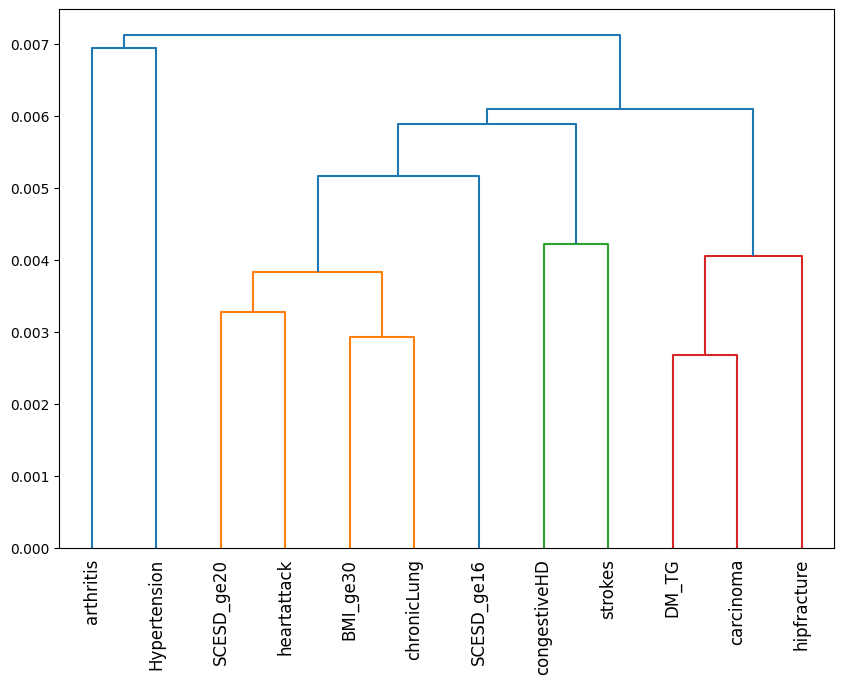

In [20]:
# Use hierarchical clustering to group diseases based on similaroty of mi scores across symptoms

linked = linkage(mi_scores_df, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=mi_scores_df.index, distance_sort='descending', show_leaf_counts=True)
plt.xticks(rotation=90)
plt.show()

# This dendogram shows us which diseases have similar mi scores for about the same symptoms

In [21]:
# Heatmap of MI scores with clustering (does not work bc of scipy runtimeerror issues)
#plt.figure(figsize=(12, 8))
#sns.clustermap(mi_scores_df, metric='euclidean', method='ward', cmap='viridis', figsize=(12, 8), standard_scale=1)
#plt.show()

In [22]:
# Cohort analysis (demographic cohort; age, gender)

/Users/nikhilkashyap/.conda/envs/BP/lib/python3.9/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


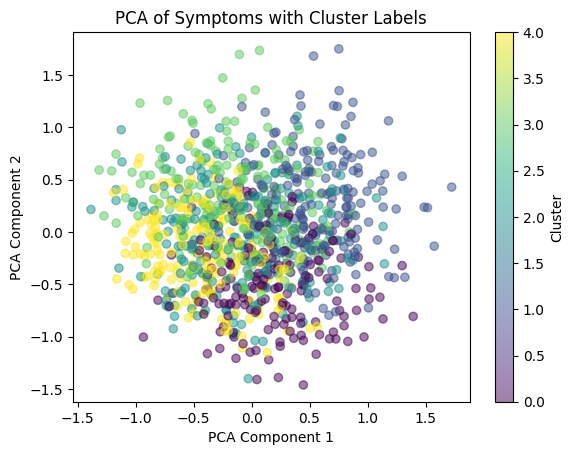

In [23]:
# Groups of people with the same symptom associations (this may later be used when making predictions)

n_clusters = 5  # adjust if needed to find the right clusters

# Use KMeans to cluster individuals based on their symptom profiles
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(df[symptom_columns].fillna(0))

# Assign cluster labels to individuals
df['symptom_cluster'] = clusters

pca = PCA(n_components=2)
symptom_pca = pca.fit_transform(df[symptom_columns].fillna(0))

# Scatter plot colored by cluster label
plt.scatter(symptom_pca[:, 0], symptom_pca[:, 1], c=df['symptom_cluster'], cmap='viridis', alpha=0.5)
plt.title('PCA of Symptoms with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### DO people develop more diseases over time (this may impact multi-morbidity profile over time)
#### Also: should we firstly group by StudyID to accumulate profiles or do we look at profiles simply as a combination of diseases and do we not care about which specific person has what for this specific study?

In [50]:
# Checking if people develop more diseases over time, this could mean that they can belong in different groups/profiles over time
df_sorted = df.sort_values(by=['studyID', 'intdate'])

df_sorted[disease_columns] = df_sorted[disease_columns].cumsum(axis=0).clip(upper=1)

df_sorted[disease_columns] = df_sorted.groupby('studyID')[disease_columns].cumsum().clip(upper=1)

df_sorted['total_diseases'] = df_sorted[disease_columns].sum(axis=1)
df_sorted['more_diseases'] = df_sorted.groupby('studyID')['total_diseases'].diff().fillna(0) > 0

study_ids_with_more_diseases = df_sorted[df_sorted['more_diseases']]['studyID'].unique()
study_ids_with_more_diseases

array([ 113,  129,  138,  158,  177,  181,  189,  194,  224,  236,  244,
        247,  275,  299,  316,  351,  355,  370,  384,  386,  429,  435,
        449,  471,  513,  529,  535,  569,  571,  607,  647,  678,  679,
        682,  686,  696,  699,  720,  741,  756,  759,  767,  782,  820,
        832,  838,  848,  849,  850,  865,  906,  956, 1017, 1026, 1042,
       1127, 1140, 1154, 1156, 1164, 1195, 1211, 1218, 1224, 1227, 1252,
       1288, 1330, 1339, 1371, 1391, 1402, 1440, 1462, 1466, 1470, 1477,
       1490, 1524, 1551, 1567, 1584, 1599, 1600, 1610, 1650, 1667, 1690,
       1709, 1764, 1789, 1813, 1818, 1849, 1857, 1875, 1880, 1883, 1886,
       1888, 1909, 1971, 1973, 1977, 2022, 2049, 2062, 2076, 2077, 2095,
       2099, 2220, 2224, 2226, 2243, 2249, 2261, 2292, 2298, 2309, 2324,
       2328, 2340, 2384, 2389, 2406, 2409, 2436, 2461, 2466, 2497, 2502,
       2503, 2508, 2531, 2535, 2545, 2569, 2570, 2571, 2578, 2595, 2609,
       2611, 2621, 2626, 2627, 2673, 2674, 2699, 27

In [52]:
# Making sure we group by studyID when looking at multi-morbidity
df[disease_columns] = df[disease_columns].astype(bool)

# Aggregate by StudyID, taking the max in each disease column (True if disease present in any row)
agg_df = df.groupby('studyID')[disease_columns].max().reset_index()

agg_df['multi_morbidity'] = agg_df[disease_columns].apply(lambda x: ', '.join(x.index[x]) if x.sum() >= 2 else np.nan, axis=1)

In [53]:
# Group people with different multi-morbidities (and those with single diseases?)
#df['multi_morbidity'] = df[disease_columns].apply(lambda x: ', '.join(x.index[x==1]) if x.sum() >= 2 else np.nan, axis=1)

# Most common multi-morbidities
common_groups = agg_df['multi_morbidity'].value_counts()

print(common_groups.head(10))

heartattack, strokes, congestiveHD, carcinoma, hipfracture, chronicLung, Hypertension, arthritis, DM_TG, BMI_ge30, SCESD_ge20, SCESD_ge16    116
heartattack, congestiveHD, carcinoma, hipfracture, chronicLung, Hypertension, arthritis, DM_TG, BMI_ge30, SCESD_ge20, SCESD_ge16              14
heartattack, strokes, congestiveHD, carcinoma, hipfracture, chronicLung, Hypertension, arthritis, BMI_ge30, SCESD_ge20, SCESD_ge16            13
heartattack, strokes, congestiveHD, carcinoma, hipfracture, chronicLung, Hypertension, DM_TG, BMI_ge30, SCESD_ge20, SCESD_ge16                12
heartattack, strokes, congestiveHD, carcinoma, chronicLung, Hypertension, arthritis, DM_TG, BMI_ge30, SCESD_ge20, SCESD_ge16                  12
heartattack, strokes, congestiveHD, carcinoma, hipfracture, chronicLung, Hypertension, arthritis, DM_TG, BMI_ge30, SCESD_ge16                 11
heartattack, strokes, congestiveHD, carcinoma, hipfracture, chronicLung, arthritis, DM_TG, BMI_ge30, SCESD_ge20, SCESD_ge16       

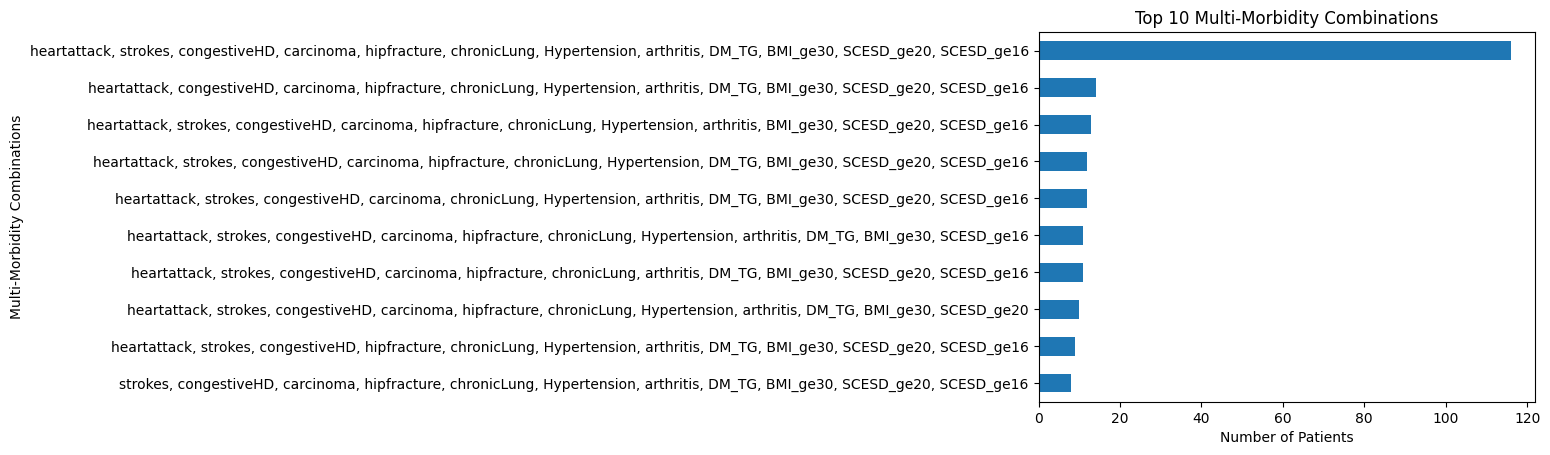

In [54]:
# Plotting multi-morbidites
top_n = 10  
common_groups.head(top_n).plot(kind='barh')
plt.xlabel('Number of Patients')
plt.ylabel('Multi-Morbidity Combinations')
plt.title('Top 10 Multi-Morbidity Combinations')
plt.gca().invert_yaxis() 
plt.show()

In [55]:
# checking how many unique multi-morbidity profiles there are in the data
print(len(agg_df['multi_morbidity'].unique()))

274


In [29]:
# Matrix that shows per multi-morbidity the symptom associations, after similarity is established we can use 
# this to make sub groups of data, so we can eventually impute the data per sub group for better accuracy
# In this cell we only calc by using count (not MI scores yet)

# make sure to have run the symptom_columns before running this

# Identify unique multi-morbidity profiles
unique_profiles = df['multi_morbidity'].unique()

# dict for co occurrences
co_occurrence_matrices = {}

for profile in unique_profiles:
    # Filter the DataFrame for the current profile
    profile_df = df[df['multi_morbidity'] == profile]
    
    # Initialize an empty matrix
    co_occurrence_matrix = np.zeros((len(symptom_columns), len(symptom_columns)))
    
    # Fill the matrix with co-occurrence counts
    for i, symptom1 in enumerate(symptom_columns):
        for j, symptom2 in enumerate(symptom_columns):
            if i <= j:  # Avoid redundant calculations
                count = profile_df[(profile_df[symptom1] == 1) & (profile_df[symptom2] == 1)].shape[0]
                co_occurrence_matrix[i, j] = count
                co_occurrence_matrix[j, i] = count
    
    # Convert the matrix to a DataFrame for readability
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=symptom_columns, columns=symptom_columns)
    co_occurrence_matrices[profile] = co_occurrence_df


In [31]:
# visualizing

# Visualize the co-occurrence matrix for each profile as a heatmap
#for profile, matrix in co_occurrence_matrices.items():
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(matrix, annot=True, cmap='viridis')
    #plt.title(f'Symptom Co-occurrence for {profile}')
    #plt.show()


### Mutual information scores for symptoms per multi-morbidity profile

In [42]:
# Now we will use MI scores to achieve the same thing:

def calculate_mutual_info_for_profile(df, profile, symptom_columns):
    profile_df = df[df['multi_morbidity'] == profile]
    n_symptoms = len(symptom_columns)
    mi_matrix = np.zeros((n_symptoms, n_symptoms))

    for i in range(n_symptoms):
        for j in range(i, n_symptoms):  # Mutual information is symmetric, so only calc once is needed
            if i == j:
                mi_matrix[i, j] = mutual_info_score(profile_df[symptom_columns[i]], profile_df[symptom_columns[i]])
            else:
                mi_score = mutual_info_score(profile_df[symptom_columns[i]], profile_df[symptom_columns[j]])
                mi_matrix[i, j] = mi_score
                mi_matrix[j, i] = mi_score  # Fill in both [i, j] and [j, i] since the matrix is symmetric

    mi_df = pd.DataFrame(mi_matrix, index=symptom_columns, columns=symptom_columns)
    return mi_df

# Store MI matrices in a dictionary, keyed by profile
mi_matrices = {}
for profile in unique_profiles:
    mi_matrices[profile] = calculate_mutual_info_for_profile(df, profile, symptom_columns)

# select which profile to see
selected_profile = unique_profiles[0]

# Print the MI matrix for the selected profile
#print(f"Mutual Information Matrix for {selected_profile}:")
#print(mi_matrices[selected_profile])



#### Frobenius norm to calc distance between matrices

In [40]:
# We can use Frobenius norm to calculate distance between matrices (with MI scores) to find similiarity and dissimilarity

# get profiles and number of profiles (we will have to narrow down nr of profiles because hundreds are too much)
profiles = list(mi_matrices.keys())
n_profiles = len(profiles)

# matrix to store the Frobenius norms
frobenius_norm_matrix = np.zeros((n_profiles, n_profiles))

# Calculate the Frobenius norms
for i in range(n_profiles):
    for j in range(n_profiles):
        # Calculate the Frobenius norm between matrices i and j
        frobenius_norm = np.linalg.norm(mi_matrices[profiles[i]] - mi_matrices[profiles[j]], 'fro')
        frobenius_norm_matrix[i, j] = frobenius_norm

# converting the Frobenius norm matrix to a pd df
frobenius_norm_df = pd.DataFrame(frobenius_norm_matrix, index=profiles, columns=profiles)


In [41]:
frobenius_norm_df

heartattack, congestiveHD, hipfracture, chronicLung, SCESD_ge16  \
heartattack, congestiveHD, hipfracture, chronic...                                           0.000000                 
strokes, congestiveHD, BMI_ge30                                                              5.268360                 
congestiveHD, carcinoma, Hypertension                                                        7.945538                 
heartattack, chronicLung                                                                     0.000000                 
heartattack, congestiveHD, hipfracture, chronic...                                           0.000000                 
...                                                                                               ...                 
heartattack, carcinoma, Hypertension, arthritis...                                           0.000000                 
heartattack, carcinoma, chronicLung, BMI_ge30                                                0.000000                 
strokes, congestiveHD, carcinoma, hipfracture, ...                                           0.000000                 
chronicLung, arthritis, DM_TG, BMI_ge30, SCESD_...                                           0.000000                 
hipfracture, chronicLung, Hypertension, BMI_ge3...                                           0.000000                 

                                                    strokes, congestiveHD, BMI_ge30  \
heartattack, congestiveHD, hipfracture, chronic...                         5.268360   
strokes, congestiveHD, BMI_ge30                                            0.000000   
congestiveHD, carcinoma, Hypertension                                      7.163126   
heartattack, chronicLung                                                   5.268360   
heartattack, congestiveHD, hipfracture, chronic...                         5.268360   
...                                                                             ...   
heartattack, carcinoma, Hypertension, arthritis...                         5.268360   
heartattack, carcinoma, chronicLung, BMI_ge30                              5.268360   
strokes, congestiveHD, carcinoma, hipfracture, ...                         5.268360   
chronicLung, arthritis, DM_TG, BMI_ge30, SCESD_...                         5.268360   
hipfracture, chronicLung, Hypertension, BMI_ge3...                         5.268360   

                                                    congestiveHD, carcinoma, Hypertension  \
heartattack, congestiveHD, hipfracture, chronic...                               7.945538   
strokes, congestiveHD, BMI_ge30                                                  7.163126   
congestiveHD, carcinoma, Hypertension                                            0.000000   
heartattack, chronicLung                                                         7.945538   
heartattack, congestiveHD, hipfracture, chronic...                               7.945538   
...                                                                                   ...   
heartattack, carcinoma, Hypertension, arthritis...                               7.945538   
heartattack, carcinoma, chronicLung, BMI_ge30                                    7.945538   
strokes, congestiveHD, carcinoma, hipfracture, ...                               7.945538   
chronicLung, arthritis, DM_TG, BMI_ge30, SCESD_...                               7.945538   
hipfracture, chronicLung, Hypertension, BMI_ge3...                               7.945538   

                                                    heartattack, chronicLung  \
heartattack, congestiveHD, hipfracture, chronic...                  0.000000   
strokes, congestiveHD, BMI_ge30                                     5.268360   
congestiveHD, carcinoma, Hypertension                               7.945538   
heartattack, chronicLung                                            0.000000   
heartattack, congestiveHD, hipfracture, chronic...           

### Hierarchical clustering to find similar or dissimilar matrices (might need to reduce noise by excluding some profiles that are less common)

/var/folders/7z/f0_7r9wx6t1_tb8663w5sy880000gn/T/ipykernel_914/2571383099.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


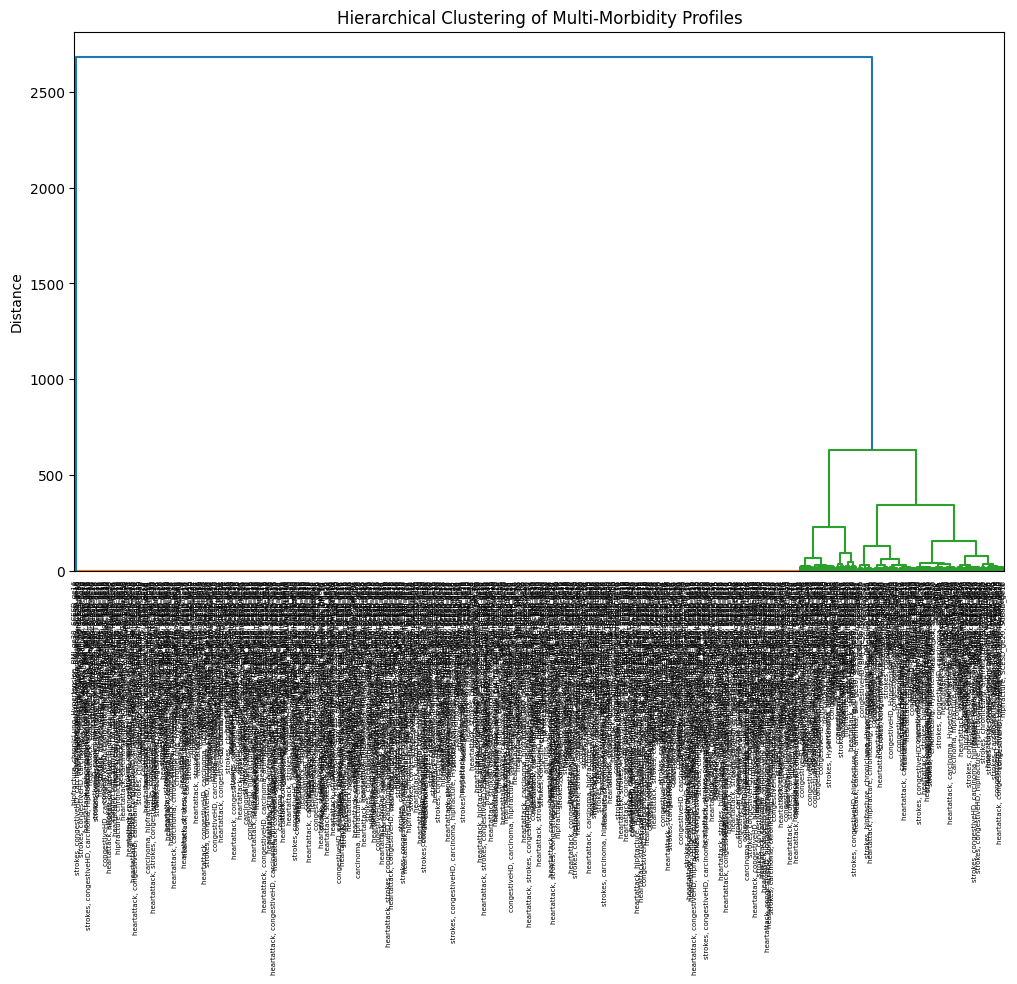

In [47]:

# Convert Frobenius norms into a format suitable for 'linkage' (distance matrix)
# Note: Ensure 'frobenius_norm_df' is symmetrical and represents distances correctly
distance_matrix = frobenius_norm_df.values

# Perform hierarchical clustering
Z = linkage(distance_matrix, method='ward')

# Plot dendrogram to visualize clustering
plt.figure(figsize=(12, 7))
dendrogram(Z, labels=frobenius_norm_df.index)
plt.title("Hierarchical Clustering of Multi-Morbidity Profiles")
plt.ylabel("Distance")
plt.show()

# Form clusters based on a distance threshold (but not sure what thesold should be (might also differ for original data??))
# For example, using a distance threshold
threshold = 0.5  # Adjust based on dendrogram and your criteria
clusters = fcluster(Z, threshold, criterion='distance')

# Map profiles to their clusters
profile_to_cluster = dict(zip(frobenius_norm_df.index, clusters))


In [39]:
# We need to measure similaroty between matrices by flattening the matrices into vectors
# We can use euclidean distance to make sub groups or for example cosine similarity

# flattening matrices with mi scores
mi_vectors = {profile: mi_matrix.values.flatten() for profile, mi_matrix in mi_matrices.items()}

# Get a list of all profiles for indexing
profiles = list(mi_matrices.keys())

# Initialize a matrix to store distances
distance_matrix = np.zeros((len(profiles), len(profiles)))

# Calculate distances
for i, profile1 in enumerate(profiles):
    for j, profile2 in enumerate(profiles):
        if i <= j:  # To avoid redundant calculations
            # Calculate Euclidean distance
            dist = euclidean(mi_vectors[profile1], mi_vectors[profile2])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Symmetric


### This may be used later to find groups in a different way

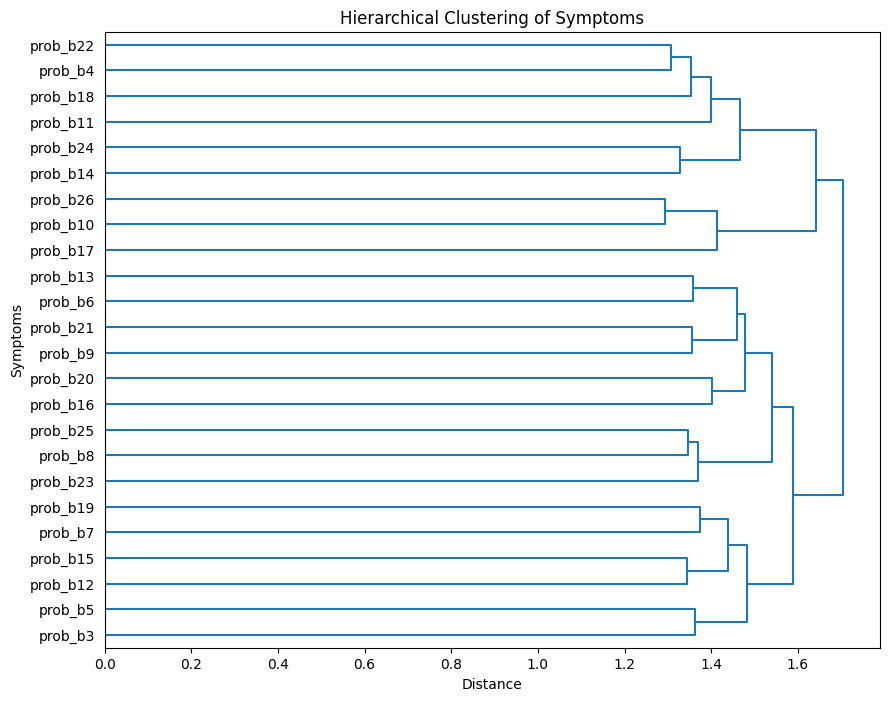

In [35]:
# Using hierarchical clustering to find out symptom associations (can also potentially be used for sub groups for imputation)

symptom_df = df[symptom_columns]

# Calculate the correlation matrix as a measure of similarity
corr_matrix = symptom_df.corr()

# Perform hierarchical clustering
Z = linkage(corr_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=corr_matrix.columns, orientation='right')
plt.title('Hierarchical Clustering of Symptoms')
plt.xlabel('Distance')
plt.ylabel('Symptoms')
plt.show()


### fOutcome over time
#### Does fOutcome increase if more symptoms are reported?

In [56]:
df['total_symptoms'] = df[symptom_columns].sum(axis=1)

correlation = df['total_symptoms'].corr(df['fOutcome'])
print(f"Correlation between total symptoms and fOutcome: {correlation}")

Correlation between total symptoms and fOutcome: 0.012386926869109574


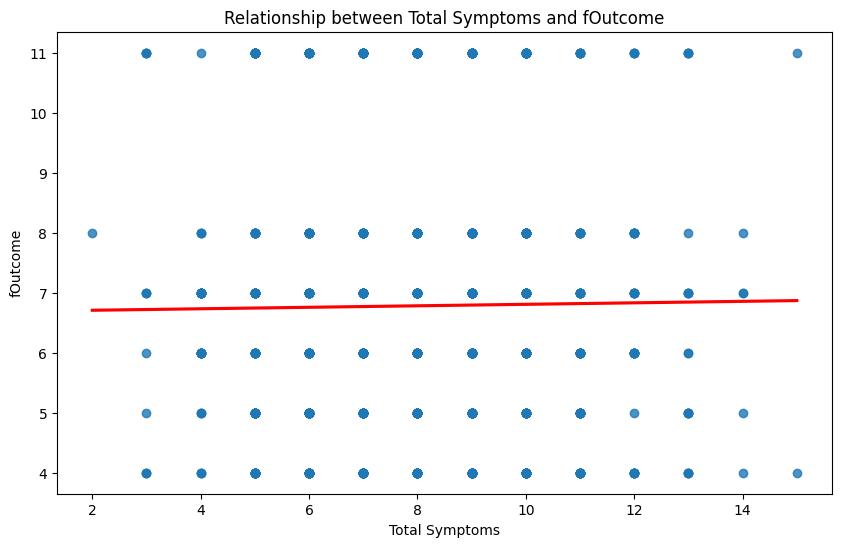

In [57]:
plt.figure(figsize=(10, 6))
sns.regplot(x='total_symptoms', y='fOutcome', data=df, ci=None, line_kws={'color': 'red'})
plt.title('Relationship between Total Symptoms and fOutcome')
plt.xlabel('Total Symptoms')
plt.ylabel('fOutcome')
plt.show()

In [61]:
# Add a constant term for the intercept
X = sm.add_constant(df['total_symptoms'])
y = df['fOutcome']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               fOutcome   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 21 Mar 2024   Prob (F-statistic):                nan
Time:                        21:11:32   Log-Likelihood:                    nan
No. Observations:                1000   AIC:                               nan
Df Residuals:                     998   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const                 nan        nan        

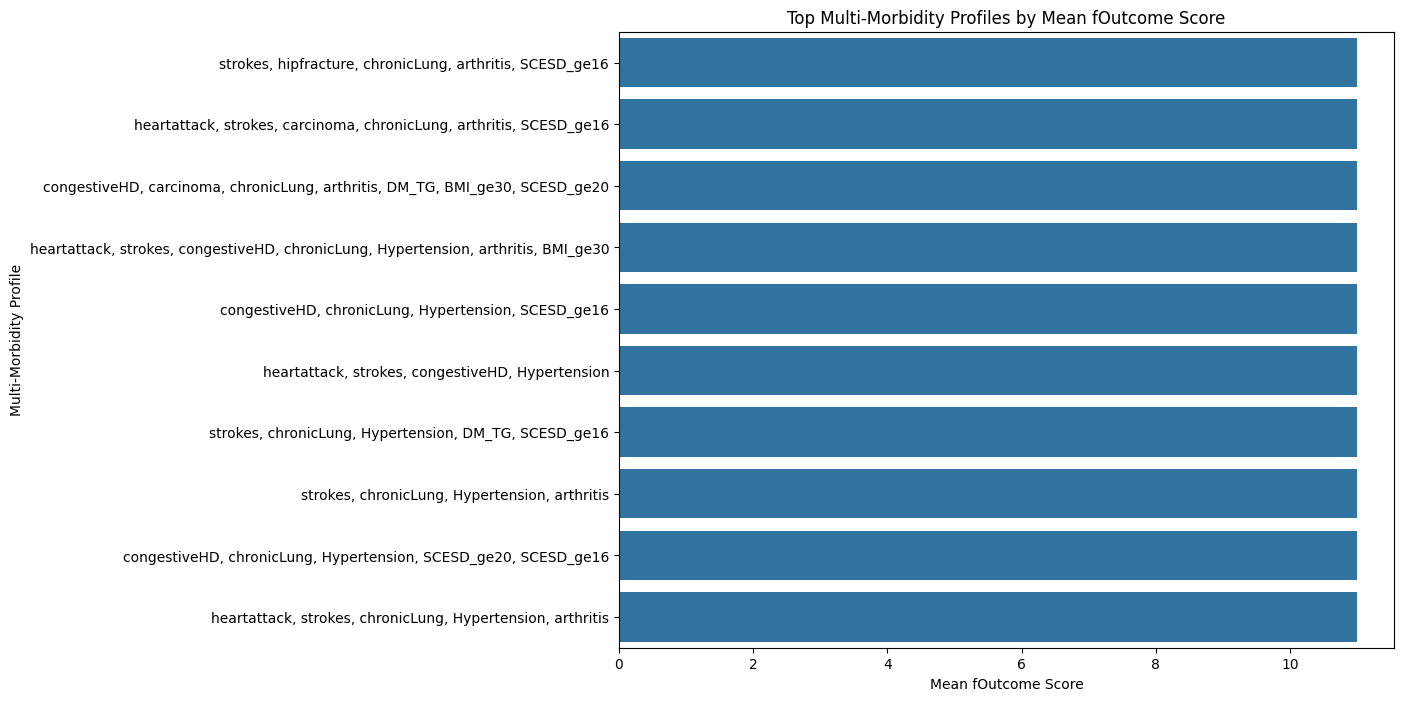

In [63]:
# Which multi-morbidity profiles yield the highest fOutcome scores?

# Calculate mean fOutcome for each multi-morbidity profile
mean_fOutcome_by_profile = df.groupby('multi_morbidity')['fOutcome'].mean().reset_index()

# calculate median fOutcome for each profile
# median_fOutcome_by_profile = df.groupby('multi_morbidity')['fOutcome'].median().reset_index()

# Sort profiles by mean fOutcome 
sorted_profiles = mean_fOutcome_by_profile.sort_values(by='fOutcome', ascending=False)

#print(sorted_profiles.head(10))  

plt.figure(figsize=(10, 8))
sns.barplot(x='fOutcome', y='multi_morbidity', data=sorted_profiles.head(10))
plt.title('Top Multi-Morbidity Profiles by Mean fOutcome Score')
plt.xlabel('Mean fOutcome Score')
plt.ylabel('Multi-Morbidity Profile')
plt.show()

### Network graphs (discontinued)

In [52]:
# Network graph for multi-morbidity/symptom associations

# We use disease and symptom columns previously made

# Initialize an empty graph
G = nx.Graph()

# Add nodes for diseases
for disease in disease_columns:
    G.add_node(disease, type='disease')

# Add nodes for symptoms
for symptom in symptom_columns:
    G.add_node(symptom, type='symptom')

# Update graph with co-occurrences
for index, row in df.iterrows():
    # For diseases
    present_diseases = [disease for disease in disease_columns if row[disease] == 1]
    for (disease1, disease2) in combinations(present_diseases, 2):
        if G.has_edge(disease1, disease2):
            G[disease1][disease2]['weight'] += 1
        else:
            G.add_edge(disease1, disease2, weight=1)
    
    # For symptoms - add edges between diseases and symptoms based on your criteria
    present_symptoms = [symptom for symptom in symptom_columns if row[symptom] == 1]
    # Example: connecting diseases to symptoms directly if they co-occur in a patient
    for disease in present_diseases:
        for symptom in present_symptoms:
            if G.has_edge(disease, symptom):
                G[disease][symptom]['weight'] += 1
            else:
                G.add_edge(disease, symptom, weight=1)



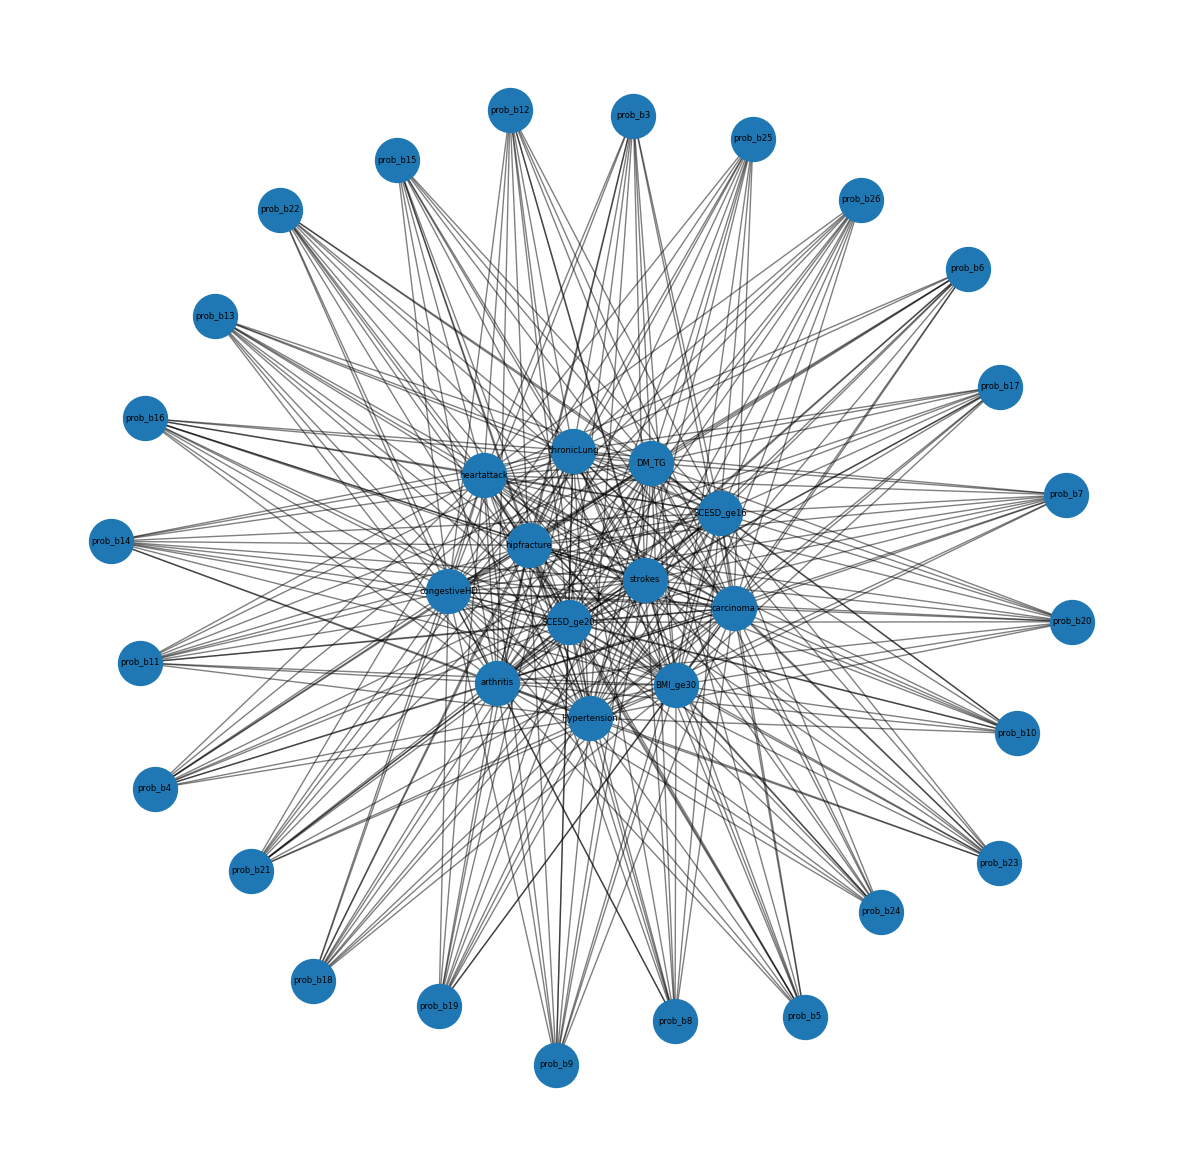

In [82]:
# Visualize graph

# Adjusting the spring layout parameters for better spacing
pos = nx.spring_layout(G, k=0.5)  # Experiment with the k value

# Increasing the figure size for better visibility
plt.figure(figsize=(15, 15))

# Drawing the network with adjusted node sizes and edge widths
nx.draw_networkx_nodes(G, pos, node_size=1000)  # Smaller nodes
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)  # Thinner edges
nx.draw_networkx_labels(G, pos, font_size=6)

plt.axis('off')
plt.show()


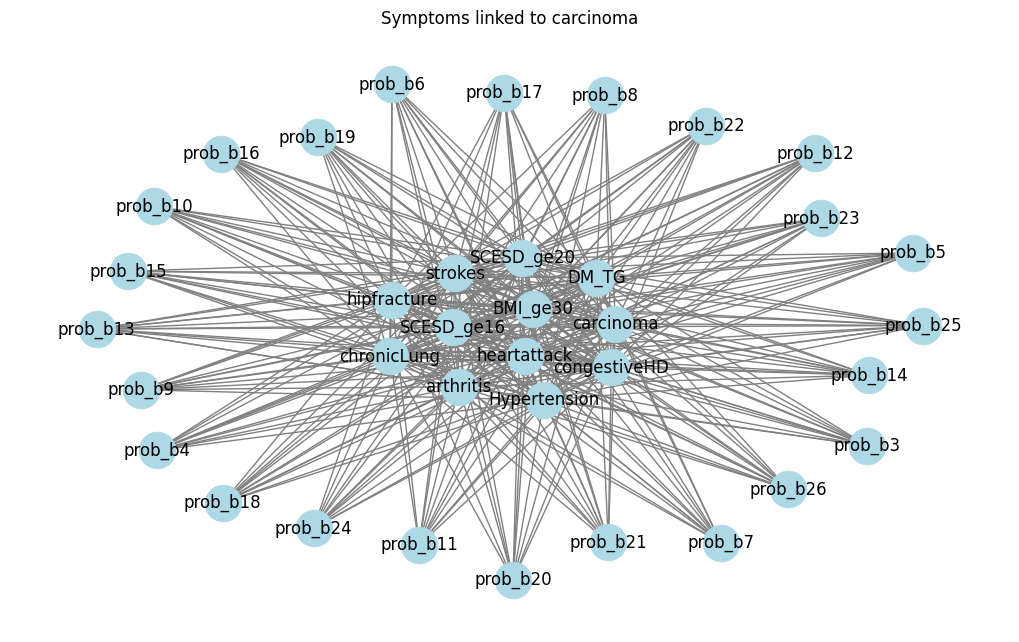

: 

In [84]:
# Zoom in per disease

disease_of_interest = 'carcinoma'
# Create a subgraph for the disease of interest
subgraph_nodes = [disease_of_interest] + list(G.neighbors(disease_of_interest))
subgraph = G.subgraph(subgraph_nodes)

# Visualize the subgraph
pos = nx.spring_layout(subgraph)  
plt.figure(figsize=(10, 6))
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color='lightblue', edge_color='gray', linewidths=0.5, font_size=12)
plt.title(f"Symptoms linked to {disease_of_interest}")
plt.show()

In [ ]:
# Network graph on symptoms and multi-morbidities

In [73]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)
#net.show("disease_symptom_network.html")

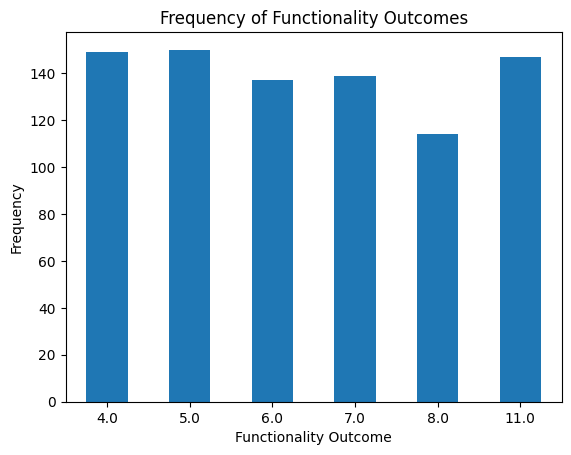

In [60]:
# fOutcome frequency
outcome_frequencies = df['fOutcome'].value_counts().sort_index()

outcome_frequencies.plot(kind='bar')
plt.title('Frequency of Functionality Outcomes')
plt.xlabel('Functionality Outcome')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

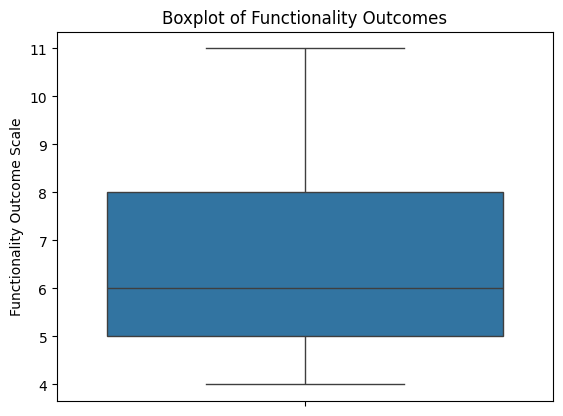

In [61]:
# fOutcome boxplot
sns.boxplot(y=df['fOutcome'])
plt.title('Boxplot of Functionality Outcomes')
plt.ylabel('Functionality Outcome Scale')
plt.show()

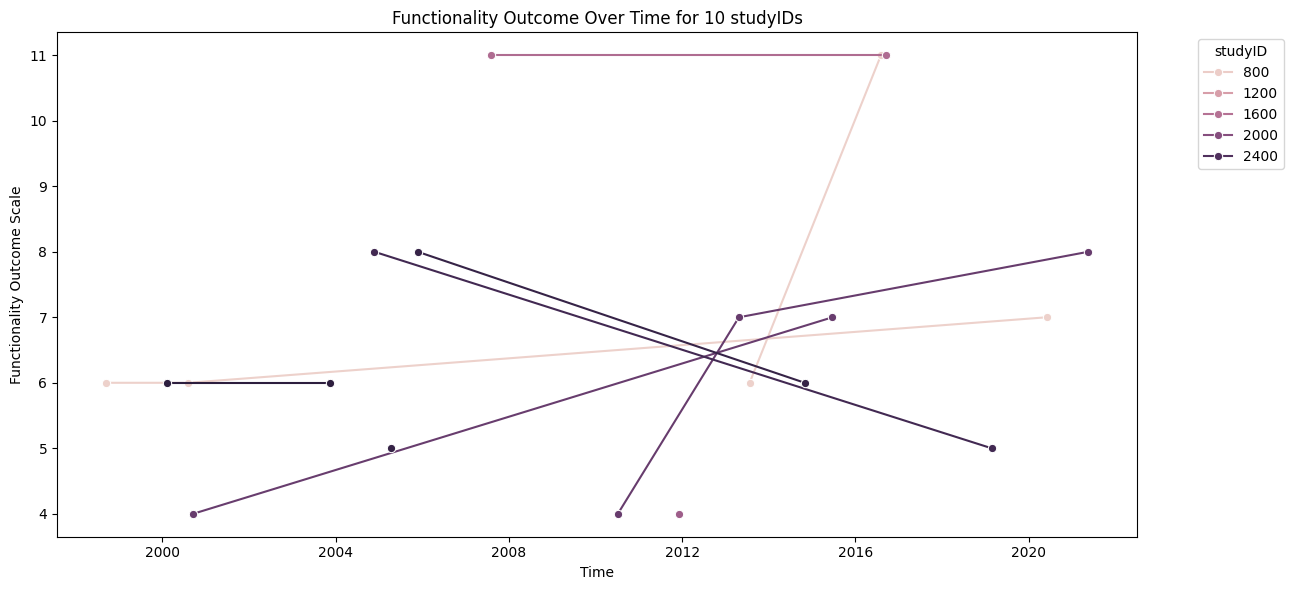

In [64]:
# fOutcome per StudyID over time
subset_studyIDs = df['studyID'].unique()[:10]
subset_df = df[df['studyID'].isin(subset_studyIDs)]

plt.figure(figsize=(13, 6))  
sns.lineplot(data=subset_df, x='intdate', y='fOutcome', hue='studyID', marker='o')
plt.title('Functionality Outcome Over Time for 10 studyIDs')
plt.xlabel('Time')
plt.ylabel('Functionality Outcome Scale')
plt.legend(title='studyID', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

In [71]:
# fOutcome matched to all multi-morbidities

# Calculate the mean fOutcome for each multi-morbidity profile
mean_outcomes = df.groupby('multi_morbidity')['fOutcome'].mean().reset_index()

# Calculate the median fOutcome for each multi-morbidity profile
median_outcomes = df.groupby('multi_morbidity')['fOutcome'].median().reset_index()

# Sort by mean fOutcome and select top 10
top_mean_outcomes = mean_outcomes.sort_values(by='fOutcome', ascending=False).head(10)

# Sort by median fOutcome and select top 10 
top_median_outcomes = median_outcomes.sort_values(by='fOutcome', ascending=False).head(10)

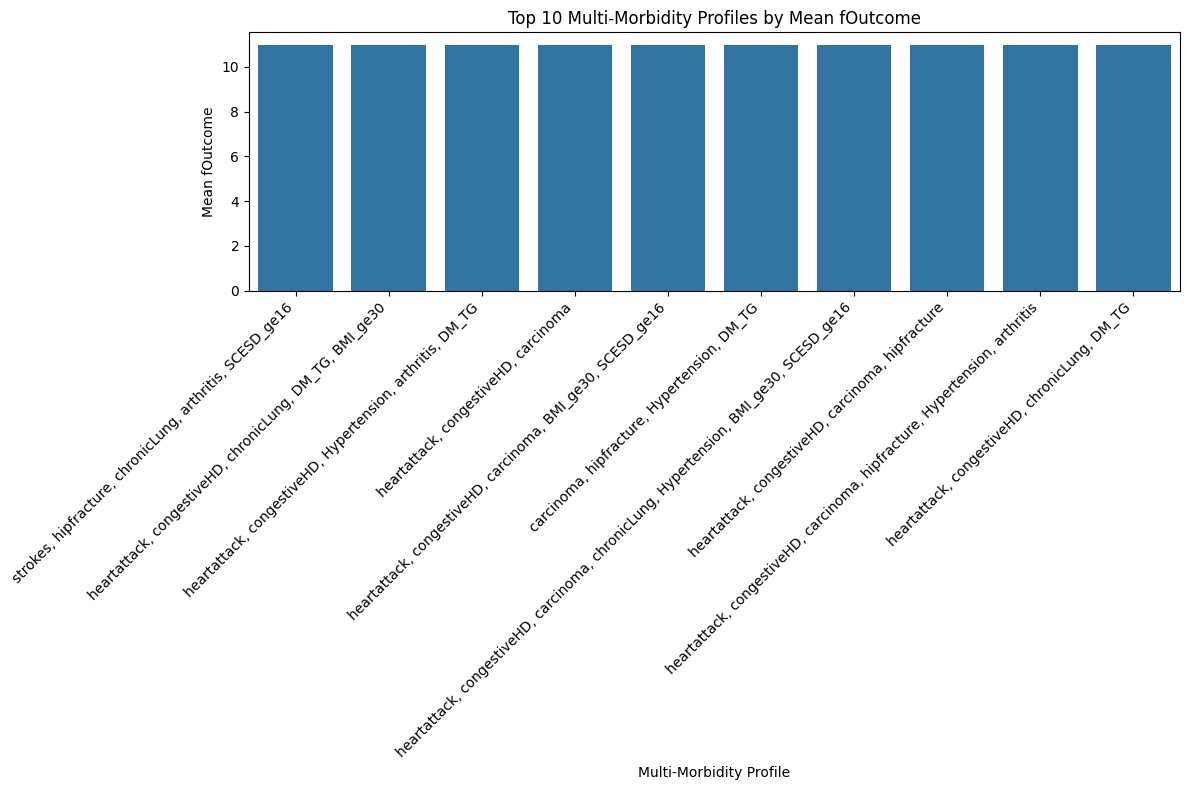

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(x='multi_morbidity', y='fOutcome', data=top_mean_outcomes)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Multi-Morbidity Profiles by Mean fOutcome')
plt.xlabel('Multi-Morbidity Profile')
plt.ylabel('Mean fOutcome')
plt.tight_layout()
plt.show()

In [23]:
# fOutcome gender

In [ ]:
# fOutcome smokers vs. non smokers

In [74]:
# fOutcome age

# Calculate the mean fOutcome for each age group
mean_outcomes_by_age = df.groupby('age_ge85')['fOutcome'].mean().reset_index()

# Calculate the median fOutcome for each age group 
median_outcomes_by_age = df.groupby('age_ge85')['fOutcome'].median().reset_index()


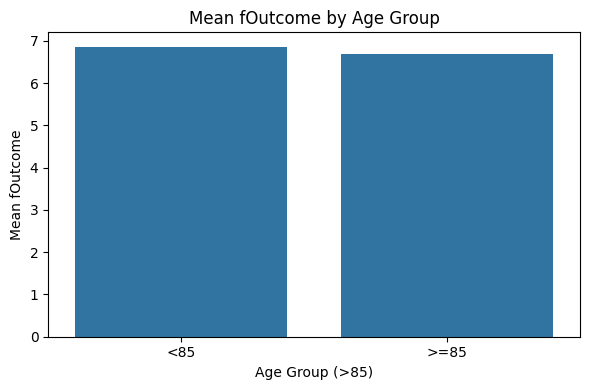

In [75]:
plt.figure(figsize=(6, 4))
sns.barplot(x='age_ge85', y='fOutcome', data=mean_outcomes_by_age) # change here again for mean/median
plt.title('Mean fOutcome by Age Group')
plt.xlabel('Age Group (>85)')
plt.ylabel('Mean fOutcome')
plt.xticks([0, 1], ['<85', '>=85'])  
plt.tight_layout()
plt.show()

### Renaming columns

In [24]:
# List of detailed symptoms based on PEP study
detailed_symptoms = [
    "pain or stiffness in your joints",
    "pain or stiffness in your back",
    "leg pain on walking",
    "weakness of your arms or legs",
    "swelling in your feet or ankles",
    "been fatigued (no energy/very tired)",
    "difficulty breathing or shortness of breath",
    "chest pain or tightness",
    "poor or decreased vision",
    "been dizzy or unsteady on your feet",
    "a fall or injury",
    "been afraid of falling",
    "cold or flu symptoms",
    "difficulty with sleeping",
    "nausea, vomiting, diarrhea, or other stomach (abdominal) problem",
    "a problem with your memory or difficulty thinking",
    "been depressed",
    "been anxious or worried",
    "frequent or painful urination",
    "lost control of your urine and wet yourself",
    "has a family member or friend become seriously ill or had an accident",
    "experienced the death or loss of a family member or friend",
    "a change in your medications",
    "a problem with alcohol"
]

# Starting column index for prob_b columns
start_index = 3

# Create a mapping of prob_b columns to the new symptom descriptions
column_mapping = {f'prob_b{i}': symptom for i, symptom in zip(range(start_index, start_index + len(detailed_symptoms)), detailed_symptoms)}

df.rename(columns=column_mapping, inplace=True)


In [25]:
df

studyID  intbloc  lastib    intdate  restrict  \
0       2595      193      64 2005-11-23       0.0   
1       2236      245     152 2015-06-22       1.0   
2       2503      186      99 2004-11-22       0.0   
3       2674      138     248 2000-02-09       NaN   
4       2609       14      65 2019-10-19       NaN   
..       ...      ...     ...        ...       ...   
995     2169       56      20 2013-04-24       1.0   
996     1339      225     109 2016-05-20       0.0   
997     2385       88       4 2004-08-05       1.0   
998     1324      250      14 2017-01-25       0.0   
999     2241       96     140 2016-01-31       1.0   

     pain or stiffness in your joints  pain or stiffness in your back  \
0                                 0.0                             0.0   
1                                 1.0                             NaN   
2                                 1.0                             0.0   
3                                 1.0                             1.0   
4                                 1.0                             NaN   
..                                ...                             ...   
995                               1.0                             NaN   
996                               NaN                             1.0   
997                               0.0                             0.0   
998                               0.0                             0.0   
999                               NaN                             NaN   

     leg pain on walking  weakness of your arms or legs  \
0                    0.0                            0.0   
1                    1.0                            NaN   
2                    1.0                            1.0   
3                    NaN                            NaN   
4                    1.0                            NaN   
..                   ...                            ...   
995                  0.0                            1.0   
996                  0.0                            1.0   
997                  1.0                            1.0   
998                  NaN                            NaN   
999                  NaN                            1.0   

     swelling in your feet or ankles  been fatigued (no energy/very tired)  \
0                                NaN                                   NaN   
1                                1.0                                   NaN   
2                                0.0                                   1.0   
3                                1.0                                   NaN   
4                                0.0                                   NaN   
..                               ...                                   ...   
995                              NaN                                   1.0   
996                              1.0                                   1.0   
997                              NaN                                   NaN   
998                              0.0                                   NaN   
999                              NaN                                   NaN   

     difficulty breathing or shortness of breath  chest pain or tightness  \
0                                            1.0                      1.0   
1                                            0.0                      NaN   
2                                            1.0                      1.0   
3                                            1.0                      1.0   
4                                            NaN                      0.0   
..                                           ...                      ...   
995                                          1.0                      NaN   
996                                          NaN                      0.0   
997                                          NaN                      1.0   
998                                          1.0               

### Contingency Tables and Chi-Squared Tests: 
- For each disease-symptom pair, create a contingency table and perform a Chi-squared test to assess the independence of occurrences. This test can help identify significant associations between diseases and symptoms.

### Correlation Coefficients: 
- For binary data (presence/absence), point-biserial correlation coefficients can be calculated between each disease and symptom to quantify the strength of association.

Also over time would be best.